In [19]:
import numpy as np
import networkx as nx
import gmatch4py as gm
import pickle
import os
import h5py
from shutil import copyfile
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
def evaluate(g1, g2):
    ged = gm.GraphEditDistance(1,1,1,1) # all edit costs are equal to 1
    result=ged.compare([g1,g2], None)
    return ged.similarity(result), ged.distance(result)

In [ ]:
def save_obj(out_path, obj, name ):
    with open(os.path.join(out_path, 'results/'+ name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(in_path, name):
    with open(os.path.join(in_path, 'results/'+ name + '.pkl'), 'rb') as f:
        return pickle.load(f)

In [ ]:
def test():
    g1 = nx.complete_bipartite_graph(5,4)
    g2 = nx.complete_bipartite_graph(6,4)
    similarity, distance = evaluate(g1, g2)
    print(similarity)
    print(distance)

In [ ]:
# gt_path = '/var/www/html/donglai/abhi/gt_pyr/'
# pd_path = '/var/www/html/abhi/pyr_summary/networkx/'
gt_path = '/var/www/html/abhi/mito_summary/mito_gt'
pd_path = '/var/www/html/abhi/mito_summary/networkx_objs'

In [ ]:
def GetWeightLess(G):
    G1 = nx.Graph()
    for e in G.edges:
        G1.add_edge(e[0], e[1])
    return G1

In [ ]:
def PrintSummary(G):
    print('Summary')
    for e in zip(G.edges, G.edges.values()):
        edge_ = 'Edge({}, {})'.format(e[0][0], e[0][1])
        wt_ = 'Weight: {:.2f}'.format(e[1]['weight'])
        print(edge_ + ' '*(20 - len(edge_)) + wt_)

In [ ]:
similarity_dict, distance_dict = {}, {}
gt_fnames = os.listdir(gt_path)
graph_ids = []
for fname in gt_fnames:
    if '.obj' in fname:
        id_ = fname.replace('cell', '').replace('.obj', '')
        graph_ids += [int(id_)]
        gt_obj = nx.read_gpickle(os.path.join(gt_path, fname))
        L_gt = nx.spectrum.laplacian_spectrum(gt_objj)
        print(len(L_gt), L_gt)
        with open(os.path.join(pd_path, '{}_networkx.obj'.format(id_)), 'rb') as f:
            pd_obj = pickle.load(f, encoding='latin1')
        L_pd = nx.spectrum.laplacian_spectrum(pd_obj)
        print(len(L_pd), L_pd)
        break
#         pd_wtless = GetWeightLess(pd_obj)
#         similarity, distance = evaluate(gt_obj, pd_wtless)
        similarity_dict[int(id_)] = similarity
        distance_dict[int(id_)] = distance
        print('Done ID {}'.format(id_))
        
save_obj(pd_path, similarity_dict, 'similarity')
save_obj(pd_path, distance_dict, 'distance')

In [ ]:
s = load_obj(pd_path, 'similarity')

In [ ]:
# store gt mitos in a place
mito_gt_path = '/var/www/html/abhi/mito_summary/mito_gt/'

In [ ]:
# read edges for redo mitos
gt_dir = '/var/www/html/abhi/mito_summary/mito_gt'
edge_path = '/var/www/html/donglai/abhi/mito_redo/gt-0403'
files_ = os.listdir(edge_path)

for fn in files_:
    if '.txt' in fn:
        fpath = os.path.join(edge_path, fn)
        try:
            dd = np.loadtxt(fpath, delimiter=',').astype(int)
            G = nx.from_edgelist(dd.tolist())
            nx.write_gpickle(G, os.path.join(gt_dir, fn.replace('.txt', '.obj')))
        except:
            continue

In [ ]:
# # copy good mitos to gt folder
# gt_dir = '/var/www/html/abhi/mito_summary/mito_gt'
# good_file = '/var/www/html/donglai/abhi/mito_redo/good.txt'

# files_ = np.loadtxt(good_file, delimiter=' ').astype(int)

# pd_path = '/var/www/html/abhi/final_data/cell{}/networkx_v0/{}_networkx.obj'
# copy_path = '/var/www/html/abhi/mito_summary/mito_gt/{}_{}.obj'

# for i in range(files_.shape[0]):
#     cell_id = files_[i][0]
#     mito_id = files_[i][1]
    
#     src = pd_path.format(cell_id, mito_id)
#     dst = copy_path.format(cell_id, mito_id)
    
#     copyfile(src, dst)

# Mito Ablation Studies

In [59]:
from sklearn.metrics.pairwise import cosine_similarity

def GetLaplacianSpectrum(G):
    return np.array(list(reversed(nx.spectrum.laplacian_spectrum(G, weight=None))))

def MitoAblation(gt_path, pd_path, only_redo=False, verbose=True):
#     similarity_dict, distance_dict = {}, {}
    gt_fnames = os.listdir(gt_path)
    graph_ids = []
    similarities = []
    redo_dir = '/var/www/html/donglai/abhi/mito_redo/gt-0403'
    redo_files = os.listdir(redo_dir)
    count_ = 0
    for fname in gt_fnames:
        if '.obj' in fname:
            count_ += 1
            cell_id = fname[0:2]
            mito_id = fname[3:].replace('.obj', '')
            id_ = cell_id + '_' + mito_id
            
            try:
                #read ground truth
                with open(os.path.join(gt_path, fname), 'rb') as f:
                    gt_obj = pickle.load(f, encoding='latin1')

                # read pred mito
                with open(pd_path.format(cell_id, mito_id), 'rb') as f:
                    pd_obj = pickle.load(f, encoding='latin1')
            except:
                continue
            L_gt = GetLaplacianSpectrum(gt_obj)
            L_pd = GetLaplacianSpectrum(pd_obj)
            k = min(len(L_gt), len(L_pd))
#             sim_ = np.linalg.norm(L_gt[:k] - L_pd[:k])
            sim_ = cosine_similarity([L_gt[:k]], [L_pd[:k]])[0][0]
#             break
#             pd_wtless = GetWeightLess(pd_obj)
#             try:
#                 similarity, distance = evaluate(gt_obj, pd_wtless)
#                 print('Done ID {}'.format(id_))
#             except:
#                 print('Error')
#                 continue
            if only_redo:
                if id_ + '.txt' in redo_files:
                    graph_ids += [id_]
                    similarities += [sim_]
            else:
                graph_ids += [id_]
                similarities += [sim_]
#             similarity_dict[id_] = similarity
#             distance_dict[id_] = distance
            if count_ % 10 == 0 and not verbose:
                print('Finished {} mitos'.format(count_))
    return graph_ids, similarities

In [60]:
# comparison with BFS+Jn+Loop+Threshold
gt_path = '/var/www/html/abhi/mito_summary/mito_gt'
pd_path = '/var/www/html/abhi/final_data/cell{}/' + 'networkx_v0/' + '{}_networkx.obj'

graph_ids_bfs_thresh4_loop, similarities_bfs_thresh4_loop = MitoAblation(gt_path, pd_path, only_redo=False)

In [61]:
# comparison with BFS+Jn+Loop+NoThreshold
gt_path = '/var/www/html/abhi/mito_summary/mito_gt'
pd_path = '/var/www/html/abhi/final_data/cell{}/' + 'networkx_0_thresh/' + '{}_networkx.obj'

graph_ids_bfs_thresh0_loop, similarities_bfs_thresh0_loop = MitoAblation(gt_path, pd_path, only_redo=False)

In [62]:
# comparison with BFS+Jn+NoLoop+Threshold
gt_path = '/var/www/html/abhi/mito_summary/mito_gt'
pd_path = '/var/www/html/abhi/final_data/cell{}/' + 'networkx_0_thresh_noloop/' + '{}_networkx.obj'

graph_ids_bfs_thresh0_noloop, similarities_bfs_thresh0_noloop = MitoAblation(gt_path, pd_path, only_redo=False)

In [63]:
# comparison with BFS+Jn+NoLoop+Threshold
gt_path = '/var/www/html/abhi/mito_summary/mito_gt'
pd_path = '/var/www/html/abhi/final_data/cell{}/' + 'networkx_4_thresh_noloop/' + '{}_networkx.obj'

graph_ids_bfs_thresh4_noloop, similarities_bfs_thresh4_noloop = MitoAblation(gt_path, pd_path, only_redo=False)

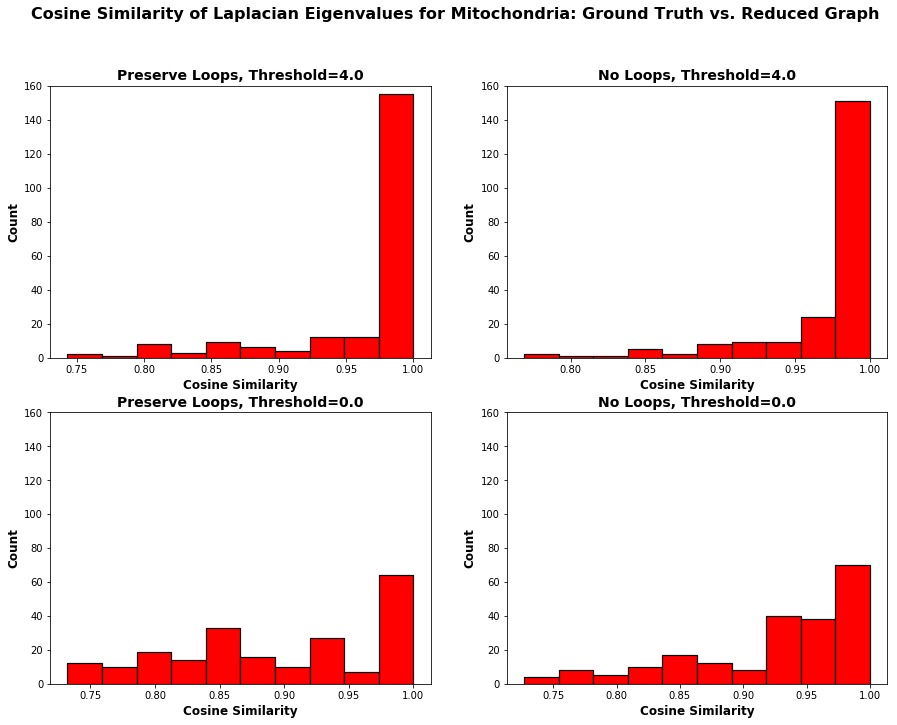

In [65]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2)
values_ = [similarities_bfs_thresh4_loop, similarities_bfs_thresh4_noloop, \
           similarities_bfs_thresh0_loop, similarities_bfs_thresh0_noloop]
names_ = ['Preserve Loops, Threshold=4.0', 'No Loops, Threshold=4.0', \
          'Preserve Loops, Threshold=0.0', 'No Loops, Threshold=0.0']

for i in range(4):
    r = i // 2
    c = i % 2
    _ = ax[r,c].hist(values_[i], bins=10, color='red', edgecolor='black', linewidth=1.2)
    _ = ax[r,c].set_xlabel('Cosine Similarity', fontsize=12, fontweight='bold')
    _ = ax[r,c].set_ylabel('Count', fontsize=12, fontweight='bold')
    _ = ax[r,c].set_title(names_[i], fontweight='bold', fontsize=14)
    _ = ax[r,c].set_ylim(0,160)
fig.suptitle('Cosine Similarity of Laplacian Eigenvalues for Mitochondria: Ground Truth vs. Reduced Graph', \
             fontweight='bold', fontsize=16)
fig.set_size_inches(15, 11)
fig.savefig('mito_ablation.png')

# Pyramidal Cell Ablation Studies

In [28]:
def PyramidAblation(gt_path, pd_path, only_redo=False, verbose=True):
#     similarity_dict, distance_dict = {}, {}
    gt_fnames = os.listdir(gt_path)
    graph_ids = []
    similarities = []
    count_ = 0
    for fname in gt_fnames:
        if '.obj' in fname:
            count_ += 1
#             cell_id = fname[0:2]
#             mito_id = fname[3:].replace('.obj', '')
            id_ = fname.replace('cell', '').replace('.obj', '')
            
            try:
                #read ground truth
                with open(os.path.join(gt_path, fname), 'rb') as f:
                    gt_obj = pickle.load(f, encoding='latin1')

                # read pred mito
                with open(pd_path.format(id_), 'rb') as f:
                    pd_obj = pickle.load(f, encoding='latin1')
            except:
                continue
            L_gt = GetLaplacianSpectrum(gt_obj)
            L_pd = GetLaplacianSpectrum(pd_obj)
            k = min(len(L_gt), len(L_pd))
            sim_ = cosine_similarity([L_gt[:k]], [L_pd[:k]])[0][0]

            if only_redo:
                if id_ + '.txt' in redo_files:
                    graph_ids += [id_]
                    similarities += [sim_]
            else:
                graph_ids += [id_]
                similarities += [sim_]
            if count_ % 10 == 0 and not verbose:
                print('Finished {} mitos'.format(count_))
    return graph_ids, similarities

In [31]:
gt_path = '/var/www/html/donglai/abhi/gt_pyr/'
pd_path = '/var/www/html/abhi/pyr_summary/networkx/{}_networkx.obj'

graph_ids, similarities_processed = PyramidAblation(gt_path, pd_path)

[5.52963389 5.14166186 4.98038597 4.85168469 4.73622854] [11.02633802  5.25026688  5.17846251  4.96475627  4.94815081]
[5.42036712 5.31914394 5.11476641 4.90501914 4.79682268] [6.18544269 5.21181263 5.15388439 4.93134743 4.79046876]
[5.47411521 5.34839429 5.06077354 4.95574526 4.7646032 ] [6.16930566 6.06148251 5.98817764 5.56915082 5.45359063]
[5.30565896 5.1496307  4.63406474 4.45518052 3.98641814] [5.53641727 5.14642024 4.92075003 4.49588205 4.02153879]
[5.86242875 5.3845997  5.30975063 5.10790835 4.87808885] [7.38445025 6.76191348 6.28004337 6.16243927 6.03699367]
[5.75218243 5.72393623 5.40554459 5.09288354 4.95059148] [6.16233127 5.72932209 5.53507719 5.38738843 5.29494381]
[5.67994991 5.49025017 5.21978746 4.97519879 4.66632192] [7.54642526 6.21161189 5.77038695 5.18627851 5.04891734]
[5.55087763 5.16726891 5.11107507 4.91691052 4.65817648] [6.31684042 5.59722799 5.42973428 5.35064356 5.18799677]
[5.48952283 5.1421701  5.0661526  4.79808881 4.60358251] [5.57153487 5.41326236 5.3

In [32]:
gt_path = '/var/www/html/donglai/abhi/gt_pyr/'
pd_path = '/var/www/html/abhi/pyr_summary/networkx_no_processing/{}_networkx.obj'

graph_ids, similarities_no_process = PyramidAblation(gt_path, pd_path)

[5.52963389 5.14166186 4.98038597 4.85168469 4.73622854] [5.7352531  5.6206123  5.54320828 5.49123335 5.48199151]
[5.42036712 5.31914394 5.11476641 4.90501914 4.79682268] [5.76113521 5.53370288 5.48075901 5.43058624 5.28091909]
[5.47411521 5.34839429 5.06077354 4.95574526 4.7646032 ] [7.18648739 6.34508054 6.29365213 6.26294756 6.25418217]
[5.30565896 5.1496307  4.63406474 4.45518052 3.98641814] [5.64108823 5.57711389 5.55467913 5.42898995 5.21540689]
[5.86242875 5.3845997  5.30975063 5.10790835 4.87808885] [6.49295549 6.41736623 6.35820044 5.70493726 5.6892268 ]
[5.75218243 5.72393623 5.40554459 5.09288354 4.95059148] [5.59651464 5.58266033 5.54681089 5.52406999 5.51501098]
[5.67994991 5.49025017 5.21978746 4.97519879 4.66632192] [5.60924856 5.58624238 5.55818841 5.54019408 5.53799136]
[5.55087763 5.16726891 5.11107507 4.91691052 4.65817648] [5.781034   5.76348388 5.72858334 5.64230497 5.57340979]
[5.48952283 5.1421701  5.0661526  4.79808881 4.60358251] [5.99077627 5.70797987 5.624363

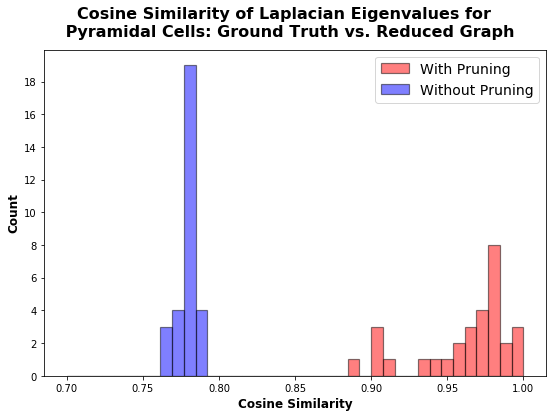

In [78]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots()
bins = np.linspace(0.7,1,40)
_ = ax.hist(similarities_processed, bins=bins, color='red', edgecolor='black', \
            linewidth=1.2, alpha=0.5, label='With Pruning')
# # _ = ax[0].set_title('Reduced Graph with Pruning')
_ = ax.hist(similarities_no_process, bins=bins, color='blue', edgecolor='black', \
            linewidth=1.2, alpha=0.5, label='Without Pruning')
_ = ax.legend(loc='best', fontsize=14)
# _ = ax[1].set_title('Reduced Graph without Pruning')
# x = np.arange(len(graph_ids))
# thick = 0.5
# _ = ax.bar(x-thick, similarities_processed, width=thick, label='With Pruning')
# _ = ax.bar(x, similarities_no_process, width=thick,label='Without Pruning')

# _ = ax.set_ylim(0.6, 1.0)
# for i in [0,1]:
# #     _ = ax[i].set_ylim(0, 15)
# #     _ = ax[i].set_xlim(0.75, 1.0)
_ = ax.set_xlabel('Cosine Similarity', fontsize=12, fontweight='bold')
_ = ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
fig.suptitle('Cosine Similarity of Laplacian Eigenvalues for \n Pyramidal Cells: Ground Truth vs. Reduced Graph', \
             fontweight='bold', fontsize=16)
fig.set_size_inches(9, 6)
fig.savefig('pyramid_ablation.png')